In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../ipsim'))
if module_path not in sys.path:
    sys.path.append(module_path)

import math
import numpy as np
import matplotlib.pyplot as plt

from ipsim import *

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from copy import deepcopy

In [2]:
class ValveType1(ProcessNode):
    Tv = 10.0/3600
    def __init__(self, name, current_position, target_position):
        super().__init__(name)
        self.current_position = current_position
        self.target_position = target_position

        self.create_output("svX")
            
    def evaluate(self):
        dt = self._model.dt()
        if dt*2 >= ValveType1.Tv:
            self.current_position = self.target_position
        else:   
            dX = dt*(self.target_position - self.current_position)/ValveType1.Tv
            self.current_position = self.current_position + dX
        self.set_result("svX", self.current_position)

    def change_value(self, name, value):
        if name == "u":
            self.target_position = value

In [3]:
class ValveType2(ProcessNode):
    Tv =  10.0/3600
    Kc = -1.4
    def __init__(self, name, current_position, target_position, liquid_inventory):
        super().__init__(name)
        self.current_position = current_position
        self.target_position  = target_position
        self.liquid_inventory = liquid_inventory

        self.create_output("svX")
        
    def evaluate(self):
        self.set_result("svX",self.current_position)
        #liquid_inventory dont used in this example       

    def change_value(self, name, value):
        if name == "u":
            self.target_position  = value
        if name == "vl":
            self.liquid_inventory = value

In [4]:
class TEOSimplified(ProcessNode):
    Rkcal = 1.987 # cal/(mol*K) constant for perfect gases in calories
    Rkj   = 8.31451 # J/(mol*K) constant for perfect gases in joulies
    rhoD  = 8.3 # kmol/m3 density of D
    T0    = 273.15  # K 0C in Kelvin
    k0    = 0.00117 # Constant for the isothermal operation
    def __init__(self, name, *
                 , Vr = 122 # m3 reactor volume
                 , Tr = 373 # K reactor temperature 
                 , N  = {"A":44.49999958429348
                        ,"B":13.53296996509594
                        ,"C":36.64788062995841
                        ,"D":110.0} #kmol - starting total molar holdup
                 ):
        super().__init__(name)
        self.Vr = Vr
        self.Tr = Tr
        self.N  = deepcopy(N)
        self.P  = 0

        self.create_input("cAi1")
        self.create_input("cBi1")
        self.create_input("cCi1")
        self.create_input("svXi1")
        self.create_input("Fmi1")

        self.create_input("cAi2")
        self.create_input("svXi2")
        self.create_input("Fmi2")

        self.create_input("svXi3")
        self.create_input("cvi3")
        self.create_input("svXi4")
        self.create_input("cvi4")

        self.create_output("Fi1")
        self.create_output("Fi2")
        self.create_output("Fi3")
        self.create_output("Fi4")
        self.create_output("P")     

        self.create_output("vl")
        self.create_output("cAo")
        self.create_output("cBo")
        self.create_output("cCo")       
    
    def evaluate(self):
        i = self.inputs()
        cAi1  = i["cAi1"]()
        cBi1  = i["cBi1"]()
        cCi1  = i["cCi1"]()
        svXi1 = i["svXi1"]()
        Fmi1  = i["Fmi1"]()
        
        cAi2  = i["cAi2"]()
        svXi2 = i["svXi2"]()
        Fmi2  = i["Fmi2"]()
        
        svXi3 = i["svXi3"]()
        cvi3  = 0.00352
        svXi4 = i["svXi4"]()
        cvi4  = 0.0417

        dt = self._model.dt()

        vd = self.N["D"]/TEOSimplified.rhoD
        vv = self.Vr - vd

        pa = self.N["A"]*TEOSimplified.Rkj*self.Tr/vv
        pb = self.N["B"]*TEOSimplified.Rkj*self.Tr/vv
        pc = self.N["C"]*TEOSimplified.Rkj*self.Tr/vv
        P = pa+pb+pc

        Fi1 = svXi1*Fmi1
        Fi2 = svXi2*Fmi2
        Fi3 = 100*svXi3*cvi3*math.sqrt(P-100) if P-100 > 0 else 0
        Fi4 = 100*svXi4*cvi4*math.sqrt(P-100) if P-100 > 0 else 0

        R = TEOSimplified.k0*math.pow(pa,1.2)*math.pow(pc,0.4) if ((pa > 0) and (pc > 0)) else 0
        dNa = (cAi1*Fi1 + cAi2*Fi2 - Fi3*pa/P - R)*dt
        dNc = (cCi1*Fi1 - Fi3*pc/P - R)*dt
        dNb = (cBi1*svXi1*Fmi1 - Fi3*pb/P)*dt
        dNd = (R - Fi4)*dt
        
        self.N["A"] = self.N["A"] + dNa  
        self.N["B"] = self.N["B"] + dNb
        self.N["C"] = self.N["C"] + dNc
        self.N["D"] = self.N["D"] + dNd

        if self.N["A"] < 0:
            self.N["A"] = 0

        if self.N["B"] < 0:
            self.N["B"] = 0

        if self.N["C"] < 0:
            self.N["C"] = 0

        if self.N["D"] < 0:
            self.N["D"] = 0
            
        self.set_result("Fi1", Fi1)
        self.set_result("Fi2", Fi2)
        self.set_result("Fi3", Fi3)
        self.set_result("Fi4", Fi4)
        self.set_result("P", P)     

        self.set_result("vl" , vd/30.0)
        self.set_result("cAo", pa/P)
        self.set_result("cBo", pb/P)
        self.set_result("cCo", pc/P)

        nA = self.N["A"]
        nB = self.N["B"]
        nC = self.N["C"]
        nD = self.N["D"]


In [5]:
def prepare_model():  
    processModel = ProcessModel("test",dt=0.1)
    node1 = ProcessInputNode("Stream1",{ "cA":0.485
                                                     , "cB":0.005
                                                     , "cC":0.51
                                                     #, "svX":0.6095327313484253#, "svX":0.6095327
                                                     , "Fmax":330.46})
    node2 = ValveType1("Stream1Valve", 0.6095327313484253, 0.6095327313484253 )
    node3 = ProcessInputNode("Stream2", {"cA":1
                                        #, "svX":0.2502232231706676 
                                        , "Fmax": 22.46})
    
    node4 = ValveType1("Stream2Valve", 0.2502232231706676, 0.2502232231706676 )
    node5 = ValveType1("Stream3Valve", 0.392577701760644, 0.392577701760644 )
    node6 = ValveType2("Stream4Valve", 0.4703024823457651, 0.4417670682730923, 0.4417670682730923 )

    processModel.add_node(node1)
    processModel.add_node(node2)
    processModel.add_node(node3)
    processModel.add_node(node4)
    processModel.add_node(node5)
    processModel.add_node(node6) 

    processModel.add_node(TEOSimplified("TEPS"))
    processModel.bond_nodes("TEPS","cAi1" , "Stream1", "cA")
    processModel.bond_nodes("TEPS","cBi1" , "Stream1", "cB")
    processModel.bond_nodes("TEPS","cCi1" , "Stream1", "cC")
    processModel.bond_nodes("TEPS","Fmi1" , "Stream1", "Fmax")
    processModel.bond_nodes("TEPS","svXi1", "Stream1Valve", "svX")

    processModel.bond_nodes("TEPS","cAi2" , "Stream2", "cA")
    processModel.bond_nodes("TEPS","Fmi2" , "Stream2", "Fmax")
    processModel.bond_nodes("TEPS","svXi2", "Stream2Valve", "svX")
    
    processModel.bond_nodes("TEPS","svXi3", "Stream3Valve", "svX")
    processModel.bond_nodes("TEPS","svXi4", "Stream4Valve", "svX")

    return  processModel

In [6]:
def run_model(process_model, iterations=60*5): #5 minutes
    parametersMetadata = (
          {"parameter":"P", "range":(2000,3000)}
        , {"parameter":"vl", "range":None } #"range":(0,1)}
        , {"parameter":"Fi1", "range":(0,300)}
        , {"parameter":"Fi2", "range":(0,30)}
        , {"parameter":"Fi3", "range":(0,100)}
        , {"parameter":"Fi4", "range":(0,200)}
        , {"parameter":"cAo", "range":(0.3,0.6)}
        , {"parameter":"cBo", "range":(0.12,0.16)}
        , {"parameter":"cCo", "range":(0.3,0.6)}
    )
    x = np.empty((iterations,len(parametersMetadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))
    triggered = False
    for _ in range(iterations):
        if _ > 20 and not triggered:
           triggered = True
           node = process_model.nodes()["Stream1"]
           node.change_value("cA", 0.480)
           node.change_value("cC", 1-0.480-0.005)

        state = process_model.next_state(("TEPS",))
        data =  []
        for metadata in parametersMetadata:
             data.append(state['TEPS'][metadata["parameter"]])

        x[_] =  data
        y[_] =  1 if state['TEPS']['P'] > 2835 else 0

    return x, parametersMetadata, y

In [7]:
def run_model_clean(process_model, iterations=60*5): #5 minutes
    parametersMetadata = (
          {"parameter":"P", "range":(2000,3000)}
        , {"parameter":"vl", "range":None } #"range":(0,1)}
        , {"parameter":"Fi1", "range":(0,300)}
        , {"parameter":"Fi2", "range":(0,30)}
        , {"parameter":"Fi3", "range":(0,100)}
        , {"parameter":"Fi4", "range":(0,200)}
        , {"parameter":"cAo", "range":(0.3,0.6)}
        , {"parameter":"cBo", "range":(0.12,0.16)}
        , {"parameter":"cCo", "range":(0.3,0.6)}
    )
    x = np.empty((iterations,len(parametersMetadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))
    triggered = False
    for _ in range(iterations):
        state = process_model.next_state(("TEPS",))
        data =  []
        for metadata in parametersMetadata:
             data.append(state['TEPS'][metadata["parameter"]])

        x[_] =  data
        y[_] =  1 if state['TEPS']['P'] > 2835 else 0

    return x, parametersMetadata, y

In [8]:
def test_ml_model(process_model, ml_model, iterations=60*5): #5 minutes
    parametersMetadata = (
          {"parameter":"P", "range":(2500,3000), "units": "kPa"}
        , {"parameter":"vl",  "units": "", "range":None  } #"range":(0,1)}
        , {"parameter":"Fi1", "range":(0,300),"units": "kmol"}
        , {"parameter":"Fi2", "range":(0,30),"units": "kmol"}
        , {"parameter":"Fi3", "range":(0,15), "units": "kmol" }
        , {"parameter":"Fi4", "range":(0,200), "units": "kmol"}
        , {"parameter":"cAo", "range":(0.3,0.6),"units": ""}       
        , {"parameter":"cBo", "range":(0.12,0.16), "units": ""}
        , {"parameter":"cCo", "range":(0.3,0.6), "units": ""}
    )
    x = np.empty((iterations,len(parametersMetadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))
    triggered = False
    for _ in range(iterations):
        if _ > 20 and not triggered:
            triggered = True
            node = process_model.nodes()["Stream1"]
            node.change_value("cA", 0.480)
            node.change_value("cC", 1-0.480-0.005)
            print(f"{_} disturbamce occurred")
       
        state = process_model.next_state(("TEPS",))
        data =  []
        for metadata in parametersMetadata:
             data.append(state['TEPS'][metadata["parameter"]])
        x[_] = data

        yres = ml_model.predict([data])[0]
        presult = 1 if yres > 0.5 else 0
        y[_] = presult

        if presult > 0.5:
            node = process_model.nodes()["Stream2Valve"]
            node.change_value("u", 0.2502232231706676 + 0.044523597506679*1.8331)
            print(f"{_}: valve 2 opened")

    return x, parametersMetadata, y

In [9]:
def show_data(x, metadata, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                plt.plot([i/10 for i in range(len(x))] ,x[:,index])
                plt.title(metadata[index]["parameter"])
    
    plt.tight_layout()
    plt.show()

In [10]:
def show_unined_data(x, xp, metadata, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                ax = plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                plt.plot([i/10 for i in range(len(x))] ,x[:,index], "--r")
                plt.plot([i/10 for i in range(len(x))] ,xp[:,index], "-g")
                plt.xlabel('h')
                plt.ylabel(metadata[index]["units"])
                plt.title(metadata[index]["parameter"])
    
    plt.tight_layout()
    fig.legend(('Uncontrolled',  'Сontrolled', ),loc='outside right upper')
    plt.show()

In [11]:
def train_logistic(x,y):
    model = LogisticRegression()
    model.fit(x, y.ravel())
    return model

In [12]:
def show_model_statistics(y, y_pred):
    f_metrics = {"Accuracy":accuracy_score
                ,"Precision":precision_score
                ,"Recall":recall_score
                ,"F1" : f1_score
                ,"Cohens kappa": cohen_kappa_score
                ,"ROC AUC": roc_auc_score
                ,"Confusion matrix": confusion_matrix}
    for metric in f_metrics:
        try:
            print(metric, f_metrics[metric](y,y_pred))
        except Exception as e:
            print(f"Metiric {metric}: {e}")

In [13]:
def run1():
    process_model = prepare_model()
    x, metadata, y = run_model(process_model, 10*12)
    #show_data(x, metadata,"test run", cols=3)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    ml_model = train_logistic(x_train, y_train)
    print(f"x,y train score = {ml_model.score(x_train, y_train)}")
    print(f"x,y test score = {ml_model.score(x_test, y_test)}")

    print("--------------------------------")
    process_model_p = prepare_model()
    xp, metadatap, yp = test_ml_model(process_model_p, ml_model, 10*12)
    #show_data(xp, metadatap,"ml test run", cols=3)
    show_model_statistics(y, yp)

    show_unined_data(x,xp,metadatap, "TES",cols=3)

In [14]:
def run_model_mixture_changes(process_model, A, B, C, xA2, iterations=60*5):
    parametersMetadata = (
          {"parameter":"P", "range":(2500,3000), "units": "kPa"}
        , {"parameter":"vl",  "units": "", "range":None  } #"range":(0,1)}
        , {"parameter":"Fi1", "range":(0,300),"units": "kmol"}
        , {"parameter":"Fi2", "range":(0,30),"units": "kmol"}
        , {"parameter":"Fi3", "range":(0,15), "units": "kmol" }
        , {"parameter":"Fi4", "range":(0,200), "units": "kmol"}
        , {"parameter":"cAo", "range":(0.3,0.6),"units": ""}       
        , {"parameter":"cBo", "range":(0.12,0.16), "units": ""}
        , {"parameter":"cCo", "range":(0.3,0.6), "units": ""}
    )
    x = np.empty((iterations,len(parametersMetadata)))
    triggered = False
    for _ in range(iterations):
        if _ > 20 and not triggered:
            triggered = True
            node = process_model.nodes()["Stream1"]
            node.change_value("cA", A)
            node.change_value("cB", B)
            node.change_value("cC", C)
            node = process_model.nodes()["Stream2Valve"]
            node.change_value("u", xA2)

        state = process_model.next_state(("TEPS",))
        data =  []
        for metadata in parametersMetadata:
             data.append(state['TEPS'][metadata["parameter"]])

        x[_] =  data
    return x, parametersMetadata

In [15]:
def show_unined_data2(xa, metadata, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    fmts = ("-k", "--r", "-b", "-.g", ":k", ":m")
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                ax = plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                for xi in range(len(xa)):
                    x = xa[xi]
                    fmt = fmts[xi]
                    plt.plot([i/10 for i in range(len(x))] ,x[:,index], fmt)
                plt.xlabel('h')
                plt.ylabel(metadata[index]["units"])
                plt.title(metadata[index]["parameter"])
    
    plt.tight_layout()
    fig.legend(('Nominal model','Underflow of A in feed 1',  'Overflow of A in feed 1', "Overflow of B underflow of A and C in feed1" ),loc='outside right upper')
    plt.show()

In [17]:
def run2():
    process_model = prepare_model()
    x, metadata, y = run_model_clean(process_model,10*12)
    process_model = prepare_model()
    x1, metadata1 = run_model_mixture_changes(process_model, 0.48, 0.005, 1-0.48-0.005, 0.2502232231706676 , 10*12)
    process_model = prepare_model()
    x2, metadata2 = run_model_mixture_changes(process_model, 0.5, 0.005, 1-0.5-0.005, 0.2502232231706676 , 10*12)
    process_model = prepare_model()
    x3, metadata3 = run_model_mixture_changes(process_model, 0.48, 0.015, 1-0.48-0.015, 0.2502232231706676 , 10*12)
    #process_model = prepare_model()
    #x4, metadata4 = run_model_mixture_changes(process_model, 0.485, 0.005, 1-0.485-0.005, 0.5002232231706676 , 10*12)
    #process_model = prepare_model()
    #x5, metadata5 = run_model_mixture_changes(process_model, 0.485, 0.005, 1-0.485-0.005, 0.0 , 10*12)

    show_unined_data2([x,x1,x2,x3,], metadata1)

In [18]:
def show_unined_data3(xa, metadata, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    fmts = ("-k", "--r", "-b", "-.g", ":k", ":m")
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                ax = plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                for xi in range(len(xa)):
                    x = xa[xi]
                    fmt = fmts[xi]
                    plt.plot([i/10 for i in range(len(x))] ,x[:,index], fmt)
                plt.xlabel('h')
                plt.ylabel(metadata[index]["units"])
                plt.title(metadata[index]["parameter"])
    
    plt.tight_layout()
    fig.legend(('Nominal model','feed 2 valve opened',  'feed 2 valve closed' ),loc='outside right upper')
    plt.show()

In [19]:
def run3():
    process_model = prepare_model()
    x, metadata, y = run_model_clean(process_model,10*12)
    process_model = prepare_model()
    x4, metadata4 = run_model_mixture_changes(process_model, 0.485, 0.005, 1-0.485-0.005, 1 , 10*12)
    process_model = prepare_model()
    x5, metadata5 = run_model_mixture_changes(process_model, 0.485, 0.005, 1-0.485-0.005, 0.0 , 10*12)

    show_unined_data3([x,x4,x5,], metadata4)

x,y train score = 1.0
x,y test score = 1.0
--------------------------------
21 disturbamce occurred
29: valve 2 opened
30: valve 2 opened
31: valve 2 opened
32: valve 2 opened
33: valve 2 opened
Accuracy 0.2833333333333333
Precision 1.0
Recall 0.054945054945054944
F1 0.10416666666666666
Cohens kappa 0.027332704995287394
ROC AUC 0.5274725274725275
Confusion matrix [[29  0]
 [86  5]]


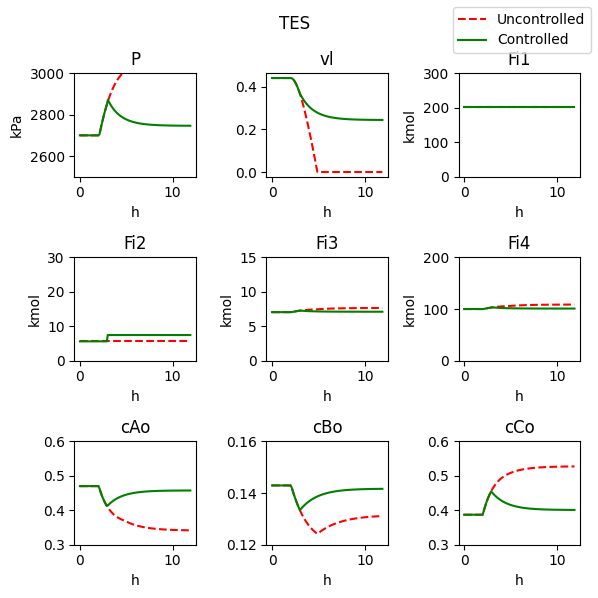

In [20]:
run1()

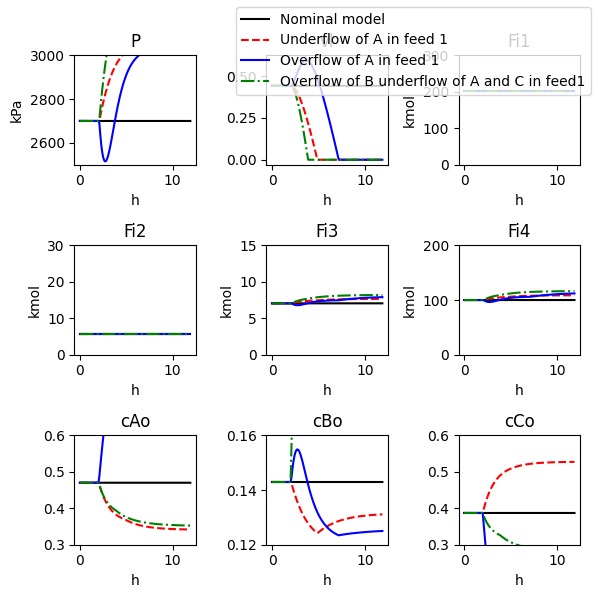

In [21]:
run2()

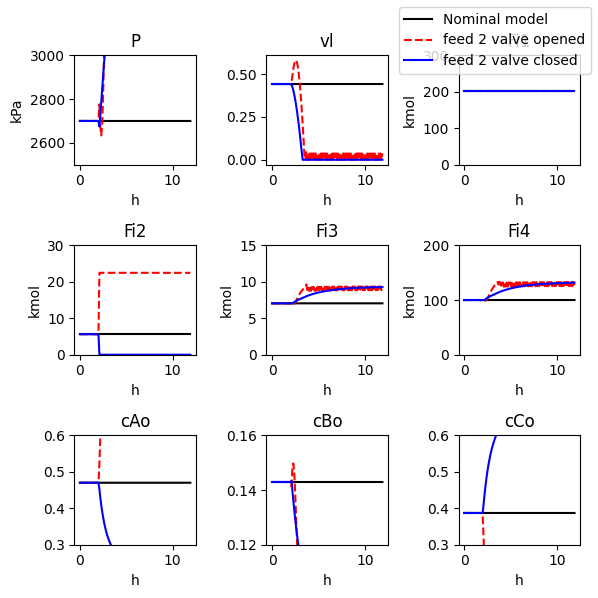

In [22]:
run3()